In [1]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 25.6 MB/s eta 0:00:00


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import tensorflow as tf
import pydicom
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import Model

In [6]:
########################
# 데이터 로딩 함수
########################
def load_dicom_images(folder_path):
    images = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith(".dcm"):
            dicom_path = os.path.join(folder_path, filename)
            dicom = pydicom.dcmread(dicom_path)
            img = dicom.pixel_array.astype(np.float32)
            img = cv2.resize(img, (256, 256))
            min_val, max_val = np.min(img), np.max(img)
            if max_val - min_val != 0:
                img = (img - min_val) / (max_val - min_val) # [0,1] 범위
            else:
                img = np.zeros_like(img)
            # [-1, 1] 스케일링 (Pix2Pix 표준)
            img = (img * 2.0) - 1.0
            images.append(img)
    return np.array(images)

########################
# 경로 설정(사용자 상황에 맞게 조정)
########################
t1post_before_folder = '/content/drive/MyDrive/tumorpred/data/train/post'
t1post_after_folder = '/content/drive/MyDrive/tumorpred/data/train/post'

t1post_before = load_dicom_images(t1post_before_folder)
t1post_after = load_dicom_images(t1post_after_folder)

# 길이가 동일한지 확인
min_length = min(len(t1post_before), len(t1post_after))
t1post_before = t1post_before[:min_length]
t1post_after = t1post_after[:min_length]

# 채널 차원 추가: (H, W) -> (H, W, 1)
t1post_before = np.expand_dims(t1post_before, axis=-1)
t1post_after = np.expand_dims(t1post_after, axis=-1)

# TensorFlow Dataset 구성
batch_size = 1
train_dataset = tf.data.Dataset.from_tensor_slices((t1post_before, t1post_after))
train_dataset = train_dataset.shuffle(buffer_size=min_length).batch(batch_size)


In [7]:
########################
# Pix2Pix 모델 정의
########################

# 다운샘플 블록
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    return result

# 업샘플 블록
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

# Generator (U-Net)
def Generator():
    inputs = layers.Input(shape=[256, 256, 1]) # 단일 채널 입력
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(1, 4, strides=2, padding='same',
                                  kernel_initializer=initializer, activation='tanh') # [-1,1]

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return Model(inputs=inputs, outputs=x)

# Discriminator (PatchGAN)
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = layers.Input(shape=[256, 256, 1], name='input_image')
    tar = layers.Input(shape=[256, 256, 1], name='target_image')

    x = layers.Concatenate()([inp, tar]) # 입력과 타겟 이미지를 채널 방향으로 concat

    down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)    # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)    # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    batchnorm1 = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return Model(inputs=[inp, tar], outputs=last)

generator = Generator()
discriminator = Discriminator()

In [9]:
########################
# Loss 함수 및 옵티마이저 정의
########################
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    # L1 loss
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

########################

In [10]:
########################
# 학습 루프 정의
########################
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return {
        'gen_total_loss': gen_total_loss,
        'gen_gan_loss': gen_gan_loss,
        'gen_l1_loss': gen_l1_loss,
        'disc_loss': disc_loss
    }

########################
# 실제 학습 실행
########################
EPOCHS = 20

for epoch in range(EPOCHS):
    print("Epoch:", epoch+1)
    for step, (inp, tar) in enumerate(train_dataset):
        losses = train_step(inp, tar)
        if step % 10 == 0:
            print(f"Step {step}, G_total: {losses['gen_total_loss']:.4f}, D_loss: {losses['disc_loss']:.4f}")


Epoch: 1
Step 0, G_total: 65.6426, D_loss: 1.7136
Step 10, G_total: 29.5169, D_loss: 1.5231
Step 20, G_total: 21.1463, D_loss: 0.9280
Step 30, G_total: 18.0320, D_loss: 1.5792
Step 40, G_total: 13.7313, D_loss: 1.3632
Step 50, G_total: 7.2436, D_loss: 1.1189
Step 60, G_total: 10.6822, D_loss: 1.7485
Step 70, G_total: 5.5540, D_loss: 1.3388
Step 80, G_total: 8.6570, D_loss: 1.4699
Step 90, G_total: 4.2756, D_loss: 1.4840
Step 100, G_total: 8.6970, D_loss: 0.9553
Step 110, G_total: 4.7227, D_loss: 1.6179
Step 120, G_total: 4.5451, D_loss: 1.2521
Step 130, G_total: 4.2752, D_loss: 1.2748
Step 140, G_total: 6.1980, D_loss: 1.2377
Step 150, G_total: 4.5443, D_loss: 1.3187
Step 160, G_total: 3.5541, D_loss: 1.4177
Step 170, G_total: 5.9436, D_loss: 1.4135
Step 180, G_total: 4.8319, D_loss: 1.2874
Step 190, G_total: 4.9969, D_loss: 1.1799
Step 200, G_total: 5.2232, D_loss: 0.9632
Step 210, G_total: 3.9270, D_loss: 1.2000
Step 220, G_total: 5.9194, D_loss: 1.1326
Step 230, G_total: 4.2666, D_l

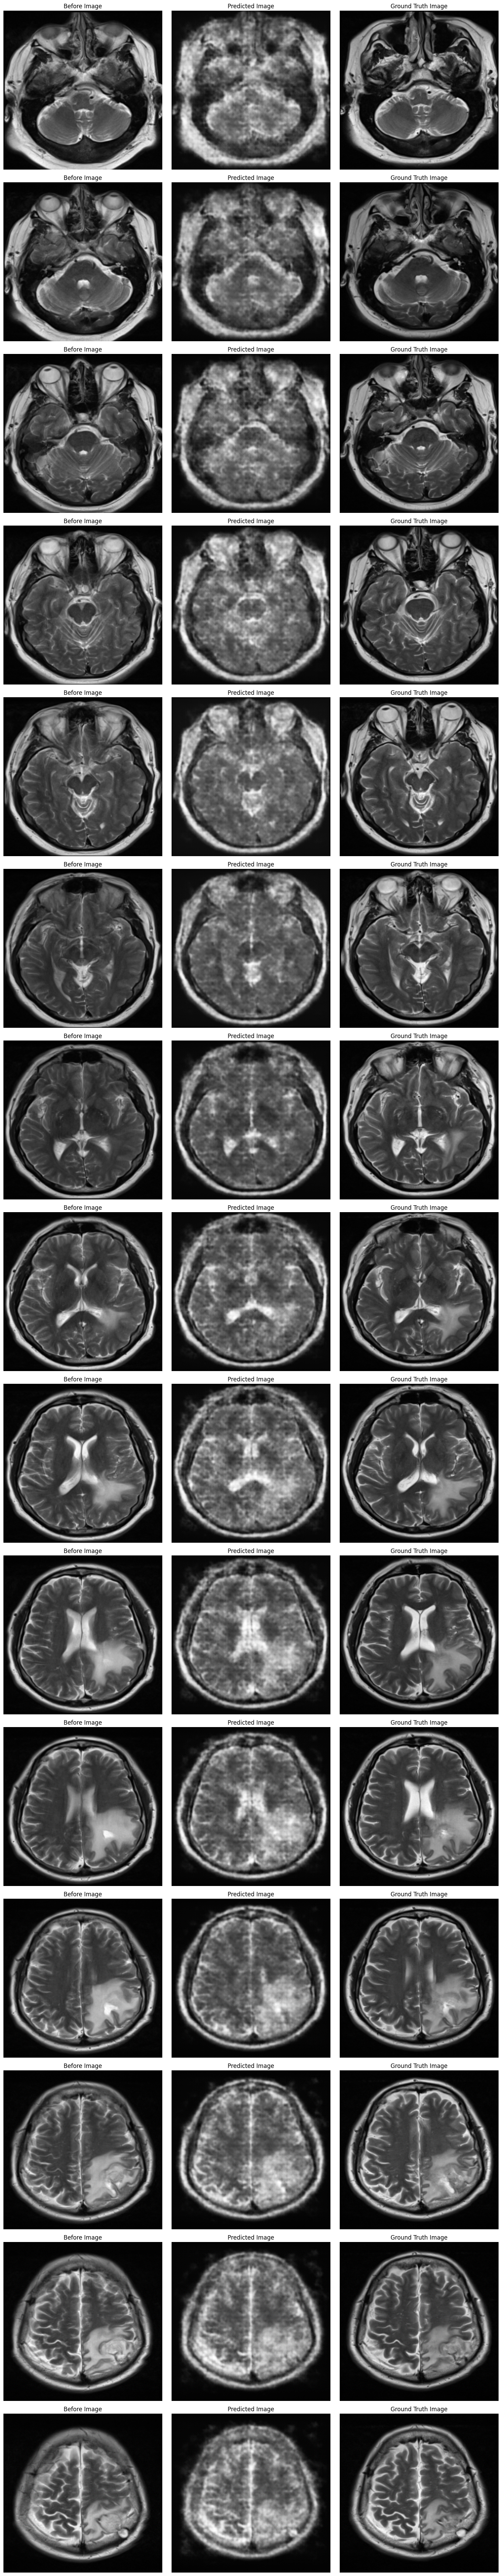

In [ ]:
def display_predictions(before_images, predicted_images, ground_truth_images, num_images=5):
    """
    Before, Predicted, Ground Truth 이미지를 나란히 출력합니다.

    Args:
        before_images (tensor): Before 이미지 텐서.
        predicted_images (tensor): Predicted 이미지 텐서.
        ground_truth_images (tensor): Ground Truth 이미지 텐서.
        num_images (int): 시각화할 이미지 개수.
    """
    plt.figure(figsize=(15, 5 * num_images))  # 전체 크기 설정
    for i in range(num_images):
        # Before 이미지
        plt.subplot(num_images, 3, 3 * i + 1)
        plt.imshow(before_images[i].squeeze(), cmap='gray')
        plt.title("Before Image")
        plt.axis('off')

        # Predicted 이미지
        plt.subplot(num_images, 3, 3 * i + 2)
        plt.imshow(predicted_images[i].squeeze(), cmap='gray')
        plt.title("Predicted Image")
        plt.axis('off')

        # Ground Truth 이미지
        plt.subplot(num_images, 3, 3 * i + 3)
        plt.imshow(ground_truth_images[i].squeeze(), cmap='gray')
        plt.title("Ground Truth Image")
        plt.axis('off')

    plt.tight_layout()  # 레이아웃 조정
    plt.show()

# 함수 실행: Before, Predicted, Ground Truth 비교
display_predictions(t1post_before, predicted_images, t1post_after, num_images=15)

In [ ]:
from skimage.metrics import structural_similarity as ssim
import numpy as np
import math

# PSNR 계산 함수
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    max_pixel = 1.0  # 정규화된 이미지의 최대값
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
    return psnr

# 모델 평가 함수
def evaluate_pix2pix_model(generator, input_images, ground_truth_images):
    total_mse = 0
    total_psnr = 0
    total_ssim = 0
    num_images = len(input_images)

    for i in range(num_images):
        # 모델을 통해 예측
        predicted_image = generator.predict(input_images[i:i+1])

        # GT와 예측값을 numpy 배열로 변환
        gt = ground_truth_images[i].squeeze()
        pred = predicted_image.squeeze()

        # 성능 지표 계산
        mse = np.mean((gt - pred) ** 2)
        psnr = calculate_psnr(gt, pred)
        ssim_value = ssim(gt, pred, data_range=pred.max() - pred.min())

        total_mse += mse
        total_psnr += psnr
        total_ssim += ssim_value

        # 이미지별 결과 출력 (옵션)
        print(f"Image {i+1}: MSE={mse:.4f}, PSNR={psnr:.2f} dB, SSIM={ssim_value:.4f}")

    # 평균 성능 지표 계산
    avg_mse = total_mse / num_images
    avg_psnr = total_psnr / num_images
    avg_ssim = total_ssim / num_images

    print("\nEvaluation Results:")
    print(f"Mean Squared Error (MSE): {avg_mse:.4f}")
    print(f"Peak Signal-to-Noise Ratio (PSNR): {avg_psnr:.2f} dB")
    print(f"Structural Similarity Index Measure (SSIM): {avg_ssim:.4f}")

# 평가 실행
evaluate_pix2pix_model(generator, input_images, t1post_after)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step
Image 1: MSE=0.0169, PSNR=17.72 dB, SSIM=0.5412
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Image 2: MSE=0.0178, PSNR=17.49 dB, SSIM=0.5249
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image 3: MSE=0.0116, PSNR=19.36 dB, SSIM=0.5527
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image 4: MSE=0.0087, PSNR=20.58 dB, SSIM=0.6021
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Image 5: MSE=0.0092, PSNR=20.36 dB, SSIM=0.6169
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image 6: MSE=0.0108, PSNR=19.68 dB, SSIM=0.6049
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image 7: MSE=0.0090, PSNR=20.46 dB, SSIM=0.6384
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image 8: MSE=0.0086, PSNR=20.65 dB, SSIM=0.6188
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Image 9: MSE=0.0110, PSNR=19.60 dB, SSIM=0.5651
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image 10: MSE=0.0121, PSNR=19.18 dB, SSIM=0.5586
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image 11: MSE=0.0082, PSNR=20.87 dB, SSIM=0.6918
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image 12: MSE

In [ ]:
import numpy as np
from scipy.linalg import sqrtm
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Load pre-trained InceptionV3 model
def load_inception_model():
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
    return model

# Resize and preprocess images
def preprocess_images(images):
    images_resized = []
    for img in images:
        img_resized = tf.image.resize(img, (299, 299)).numpy()
        img_preprocessed = preprocess_input(img_resized)
        images_resized.append(img_preprocessed)
    return np.array(images_resized)

# Calculate FID
def calculate_fid(real_images, generated_images, model):
    # Preprocess images
    real_images = preprocess_images(real_images)
    generated_images = preprocess_images(generated_images)

    # Calculate feature embeddings
    real_features = model.predict(real_images)
    gen_features = model.predict(generated_images)

    # Calculate mean and covariance
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_gen, sigma_gen = np.mean(gen_features, axis=0), np.cov(gen_features, rowvar=False)

    # Calculate squared difference between means
    diff = mu_real - mu_gen
    diff_squared = np.sum(diff**2)

    # Calculate the trace of the product of covariance matrices
    covmean = sqrtm(sigma_real.dot(sigma_gen))
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff_squared + np.trace(sigma_real + sigma_gen - 2 * covmean)
    return fid

# Example usage
if __name__ == "__main__":
    # Load real and generated images (shape: [N, H, W, C])
    # Replace these with your real and generated image arrays
    real_images = np.random.rand(100, 256, 256, 3)
    generated_images = np.random.rand(100, 256, 256, 3)

    # Load InceptionV3 model
    inception_model = load_inception_model()

    # Calculate FID
    fid_value = calculate_fid(real_images, generated_images, inception_model)
    print(f"FID: {fid_value:.4f}")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
FID: 0.0236
